In [1]:
!pip install pyspark
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=2de8753a334e90a24723f438190b0fb031cd8880507627caafff3a89f7d2bdfb
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/publi

In [2]:
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import stddev,countDistinct,count,avg,col
from pyspark.sql.functions import when
from pyspark.sql.functions import mean

from pyspark.sql.types import IntegerType
from sklearn.impute import SimpleImputer

In [3]:
data_as_csv = pd.read_csv('processed_data_with_group.csv')

In [4]:
print(data_as_csv.head())

   Grup  Numar Data_deces/externare  Stare  Varsta     Sex  \
0     1      1       5/4/2012 19:28  alive      72  Female   
1     1      2       8/28/2012 2:39  alive      75    Male   
2     1      3      11/22/2011 9:03  alive      83    Male   
3     1      4       6/20/2012 6:15  alive      43    Male   
4     1      5       7/23/2011 2:41  alive      75    Male   

   Indice_de_masa_corporala  Data_internarii Hipertensiv Fibrilatie_atriala  \
0                 37.588179  4/26/2012 22:48          nu                 nu   
1                 30.188278   8/25/2012 7:29          nu                 nu   
2                 26.572634  10/30/2011 7:37          nu                 nu   
3                 83.264629  5/28/2012 15:25          nu                 nu   
4                 31.824842   7/3/2011 20:25          da                 nu   

   ... Sodiu_din_sange Calciu_din_sange     Clorura Interval_anionic  \
0  ...      138.750000         7.463636  109.166667        13.166667   
1  ...  

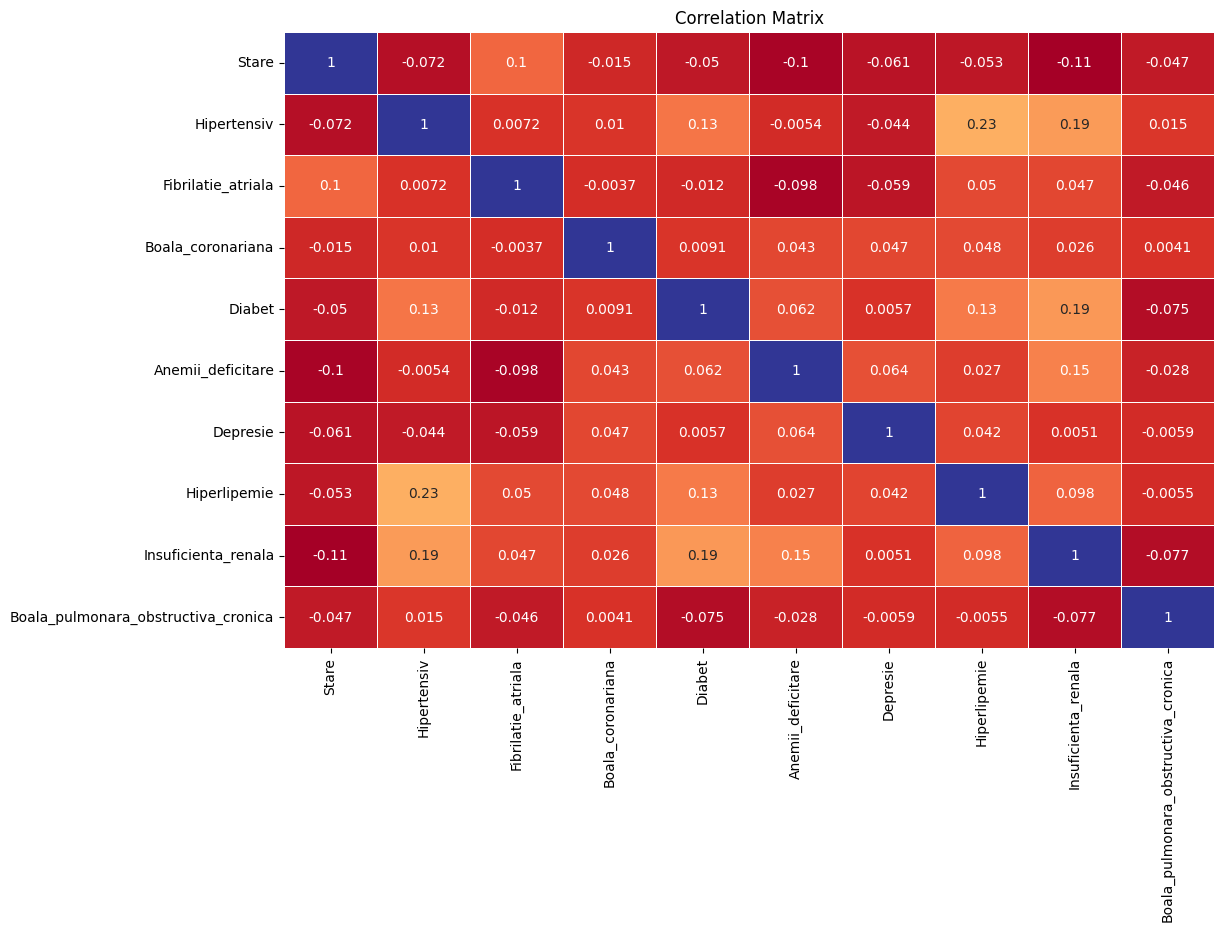

                                                         Correlation
Hiperlipemie        Hipertensiv                             0.226478
Insuficienta_renala Hipertensiv                             0.192738
Diabet              Insuficienta_renala                     0.187581
Insuficienta_renala Anemii_deficitare                       0.150904
Hiperlipemie        Diabet                                  0.134299
Diabet              Hipertensiv                             0.129122
Fibrilatie_atriala  Stare                                   0.100975
Hiperlipemie        Insuficienta_renala                     0.098025
Anemii_deficitare   Depresie                                0.063777
Diabet              Anemii_deficitare                       0.062037
Fibrilatie_atriala  Hiperlipemie                            0.049866
Boala_coronariana   Hiperlipemie                            0.047576
Fibrilatie_atriala  Insuficienta_renala                     0.047187
Depresie            Boala_coronari

In [66]:
from sklearn.impute import SimpleImputer

dataframe = data_as_csv

# ----------------Target Column-------------------------------------------------
dataframe['Stare'] = dataframe['Stare'].replace({'alive': 0, 'dead': 1})
# --------------------Categorical Columns---------------------------------------
dataframe['Hipertensiv'] = dataframe['Hipertensiv'].replace({'nu': 0,'da': 1})
dataframe['Fibrilatie_atriala'] = dataframe['Fibrilatie_atriala'].replace({'nu': 0,'da': 1})
dataframe['Boala_coronariana'] = dataframe['Boala_coronariana'].replace({'nu': 0,'da': 1})
dataframe['Diabet'] = dataframe['Diabet'].replace({'nu': 0,'da': 1})
dataframe['Anemii_deficitare'] = dataframe['Anemii_deficitare'].replace({'nu': 0,'da': 1})
dataframe['Depresie'] = dataframe['Depresie'].replace({'nu': 0,'da': 1})
dataframe['Hiperlipemie'] = dataframe['Hiperlipemie'].replace({'nu': 0,'da': 1})
dataframe['Insuficienta_renala'] = dataframe['Insuficienta_renala'].replace({'nu': 0,'da': 1})
dataframe['Boala_pulmonara_obstructiva_cronica'] = dataframe['Boala_pulmonara_obstructiva_cronica'].replace({'nu': 0,'da': 1})
# ------------------------------------------------------------------------------

label_x = dataframe.drop(columns='Stare')
label_y = dataframe[['Stare']]

simpleImp = SimpleImputer(missing_values=np.nan, strategy='mean')
column = label_x.select_dtypes(include='float64').columns

simpleImp.fit(label_x[column])
label_x[column] = simpleImp.transform(label_x[column])

SimpleImp =  SimpleImputer(missing_values=np.nan, strategy="most_frequent")
SimpleImp.fit(label_y)

label_y = SimpleImp.transform(label_y)
label_y = pd.DataFrame(label_y, columns=['Stare'], dtype='int64')

df = label_x.copy()
df['Stare'] = label_y
df.groupby(by=('Grup')).describe().round().T
col = ['Stare','Sex','Hipertensiv','Fibrilatie_atriala','Boala_coronariana','Diabet','Anemii_deficitare','Depresie','Hiperlipemie','Insuficienta_renala','Boala_pulmonara_obstructiva_cronica']
corr = df[col].corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='RdYlBu', linewidths=0.5, cbar=False);
# Create the heatmap
plt.tick_params(axis='both', labelsize=10)
# Add a title
plt.title("Correlation Matrix", fontsize=12)
# Display the heatmap
plt.show()

corr_df = pd.DataFrame(corr.unstack().sort_values(ascending=False), columns=['Correlation'])
corr_df = corr_df.drop_duplicates().dropna()
corr_df = corr_df[(corr_df['Correlation'] < 1) & (corr_df['Correlation'] > -1)]
top_pairs = corr_df.nlargest(20, 'Correlation')
print(top_pairs)

In [58]:
import pandas as pd
from scipy.stats import chi2_contingency

# Încărcați setul de date într-un DataFrame
df = pd.read_csv("processed_data.csv")

# Selectați doar coloanele categorice
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()

# Inițializați un DataFrame pentru a stoca rezultatele
correlation_matrix = pd.DataFrame(index=categorical_columns, columns=["Cramér's V"])

# Calculează coeficientul Cramér's V pentru fiecare coloană categorică
for column in categorical_columns:
    confusion_matrix = pd.crosstab(df[column], df["Stare"])
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    cramers_v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    correlation_matrix.loc[column, "Cramér's V"] = cramers_v

# Sortați valorile în ordine descrescătoare
correlation_matrix.sort_values(by="Cramér's V", ascending=False, inplace=True)

# Afișați rezultatele
print(correlation_matrix)

<ipython-input-58-5d8cd05adb60>:23: RuntimeWarning:

invalid value encountered in double_scalars



                                    Cramér's V
Stare                                  0.99948
Insuficienta_renala                   0.107575
Fibrilatie_atriala                    0.100019
Anemii_deficitare                     0.098529
Hipertensiv                           0.071203
Depresie                              0.059323
Hiperlipemie                          0.051946
Diabet                                0.048401
Boala_pulmonara_obstructiva_cronica   0.045334
Sex                                   0.019426
Boala_coronariana                      0.00873
Data_internarii                            0.0
Data_deces/externare                       NaN


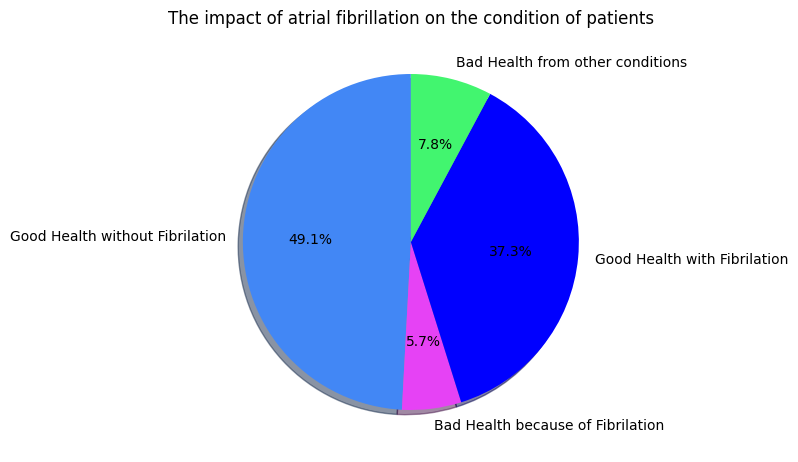

In [68]:
df = data_as_csv 
fig = plt.figure(figsize=(12,7)) 

ax2 = fig.add_axes([0.1,0.4, 0.4,0.6]) 
lab = ['Good Health without Fibrilation', 'Bad Health because of Fibrilation', 'Good Health with Fibrilation', 'Bad Health from other conditions'] 
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

#42f56f
ax2.pie(df.groupby(by=['Fibrilatie_atriala','Stare']).Stare.count(), autopct= '%1.1f%%', shadow=True,startangle=90, labels=lab,colors=colors) 
plt.title('The impact of atrial fibrillation on the condition of patients') 
plt.show()

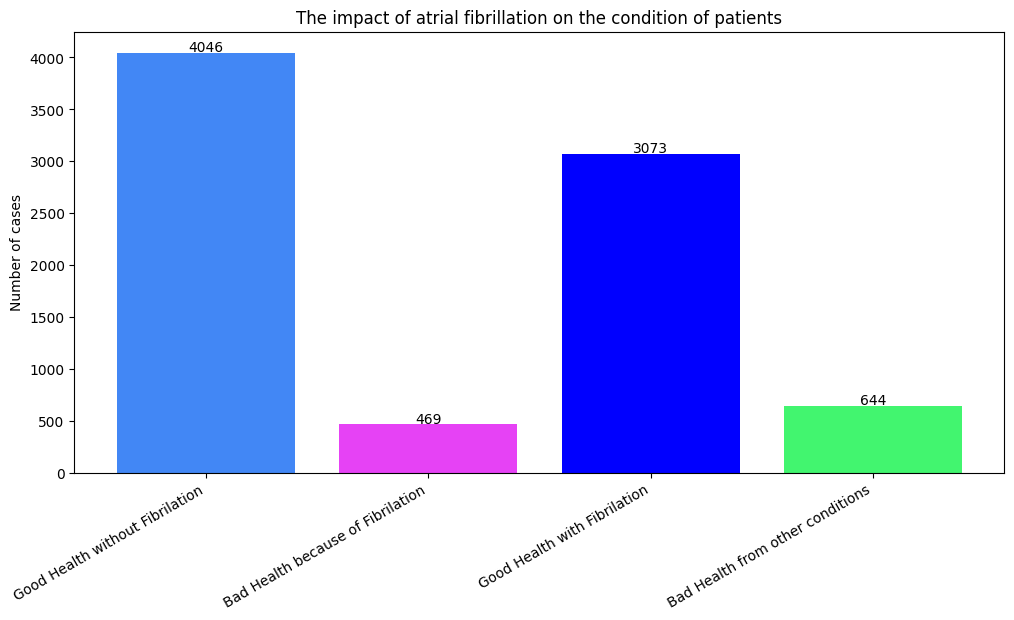

In [81]:
import matplotlib.pyplot as plt

# Date de exemplu
lab = ['Good Health without Fibrilation', 'Bad Health because of Fibrilation', 'Good Health with Fibrilation', 'Bad Health from other conditions'] 
counts = df.groupby(by=['Fibrilatie_atriala', 'Stare']).Stare.count()

# Culorile dorite pentru fiecare categorie
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

# Crearea graficului bar chart
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(lab, counts,color=colors)

# Adăugarea valorilor pentru fiecare bară
for i, v in enumerate(counts):
    ax.text(i, v + 10, str(v), ha='center')

# Etichetele axelor
ax.set_ylabel('Number of cases')

# Titlul graficului
plt.title('The impact of atrial fibrillation on the condition of patients')
ax.bar(lab, counts, color=colors)
plt.xticks(rotation=30, ha='right')
plt.subplots_adjust(bottom=0.25)
# Afișarea graficului
plt.show()

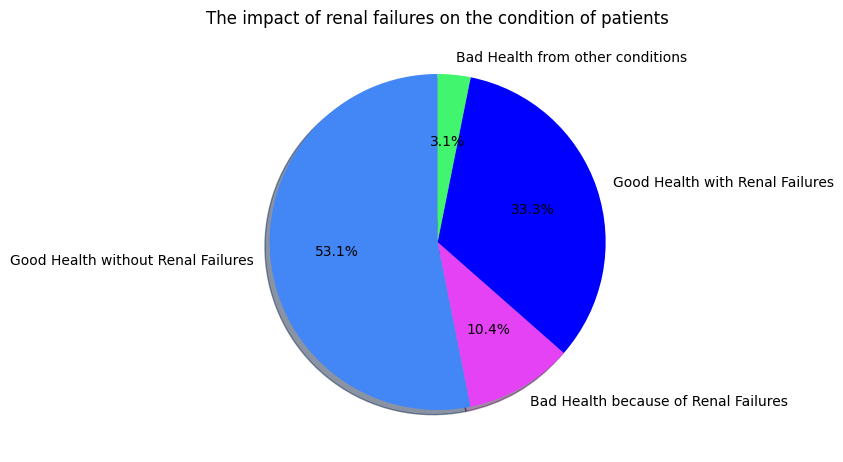

In [82]:
df = data_as_csv 
fig = plt.figure(figsize=(12,7)) 

ax2 = fig.add_axes([0.1,0.4, 0.4,0.6]) 
lab = ['Good Health without Renal Failures', 'Bad Health because of Renal Failures', 'Good Health with Renal Failures', 'Bad Health from other conditions'] 
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

#42f56f
ax2.pie(df.groupby(by=['Insuficienta_renala','Stare']).Stare.count(), autopct= '%1.1f%%', shadow=True,startangle=90, labels=lab,colors=colors) 
plt.title('The impact of renal failures on the condition of patients') 
plt.show()

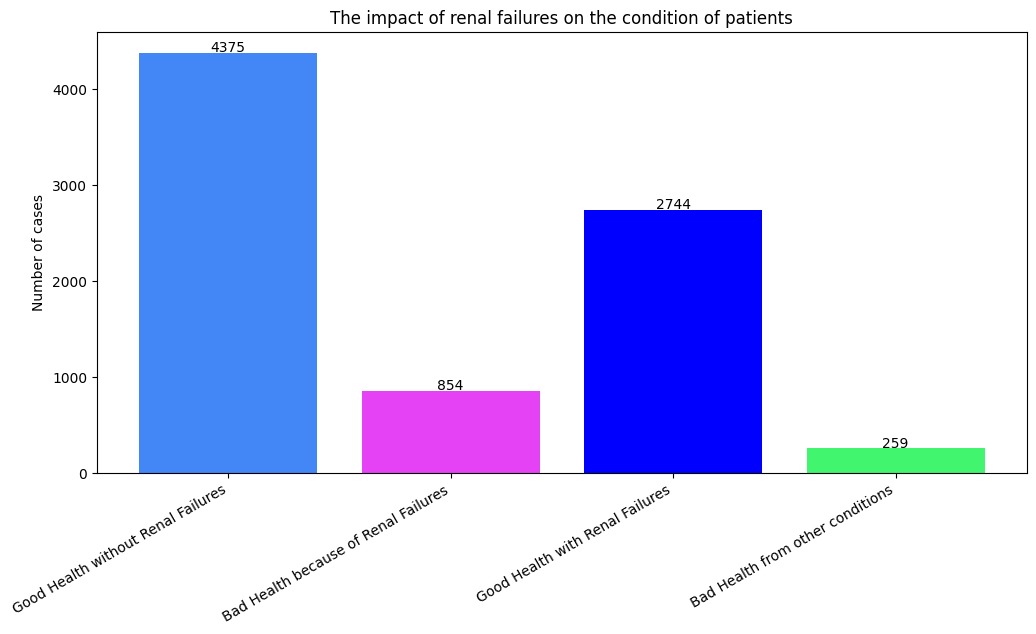

In [83]:
import matplotlib.pyplot as plt

# Date de exemplu
lab = ['Good Health without Renal Failures', 'Bad Health because of Renal Failures', 'Good Health with Renal Failures', 'Bad Health from other conditions'] 
counts = df.groupby(by=['Insuficienta_renala', 'Stare']).Stare.count()

# Culorile dorite pentru fiecare categorie
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

# Crearea graficului bar chart
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(lab, counts,color=colors)

# Adăugarea valorilor pentru fiecare bară
for i, v in enumerate(counts):
    ax.text(i, v + 10, str(v), ha='center')

# Etichetele axelor
ax.set_ylabel('Number of cases')

# Titlul graficului
plt.title('The impact of renal failures on the condition of patients')
ax.bar(lab, counts, color=colors)
plt.xticks(rotation=30, ha='right')
plt.subplots_adjust(bottom=0.25)
# Afișarea graficului
plt.show()

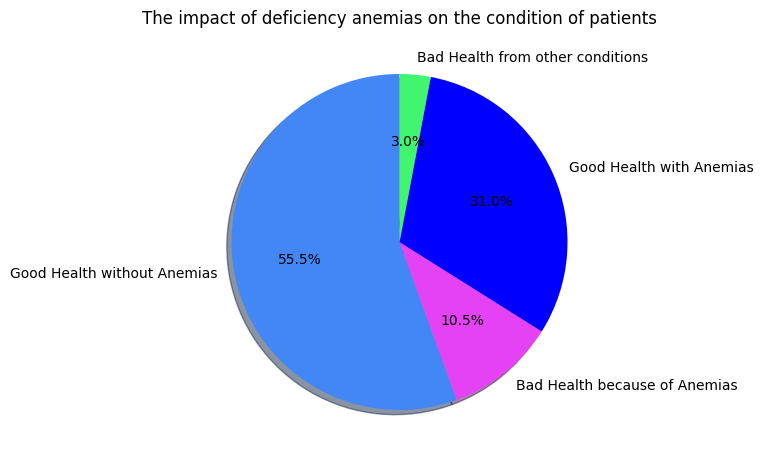

In [84]:
df = data_as_csv 
fig = plt.figure(figsize=(12,7)) 

ax2 = fig.add_axes([0.1,0.4, 0.4,0.6]) 
lab = ['Good Health without Anemias', 'Bad Health because of Anemias', 'Good Health with Anemias', 'Bad Health from other conditions'] 
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

#42f56f
ax2.pie(df.groupby(by=['Anemii_deficitare','Stare']).Stare.count(), autopct= '%1.1f%%', shadow=True,startangle=90, labels=lab,colors=colors) 
plt.title('The impact of deficiency anemias on the condition of patients') 
plt.show()

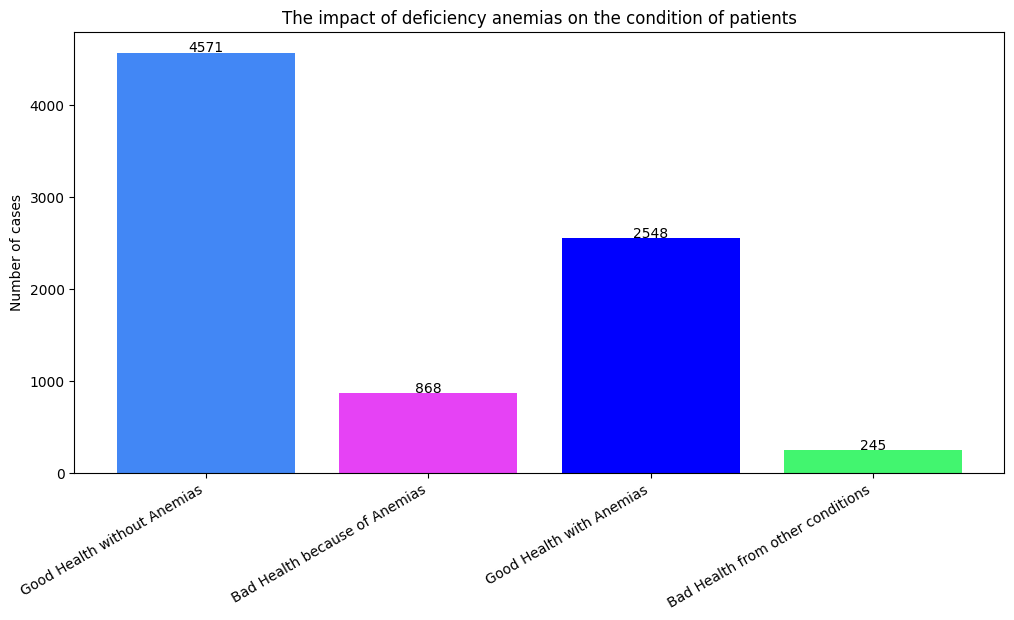

In [85]:
import matplotlib.pyplot as plt

# Date de exemplu
lab = ['Good Health without Anemias', 'Bad Health because of Anemias', 'Good Health with Anemias', 'Bad Health from other conditions'] 
counts = df.groupby(by=['Anemii_deficitare', 'Stare']).Stare.count()

# Culorile dorite pentru fiecare categorie
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

# Crearea graficului bar chart
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(lab, counts,color=colors)

# Adăugarea valorilor pentru fiecare bară
for i, v in enumerate(counts):
    ax.text(i, v + 10, str(v), ha='center')

# Etichetele axelor
ax.set_ylabel('Number of cases')

# Titlul graficului
plt.title('The impact of deficiency anemias on the condition of patients')
ax.bar(lab, counts, color=colors)
plt.xticks(rotation=30, ha='right')
plt.subplots_adjust(bottom=0.25)
# Afișarea graficului
plt.show()

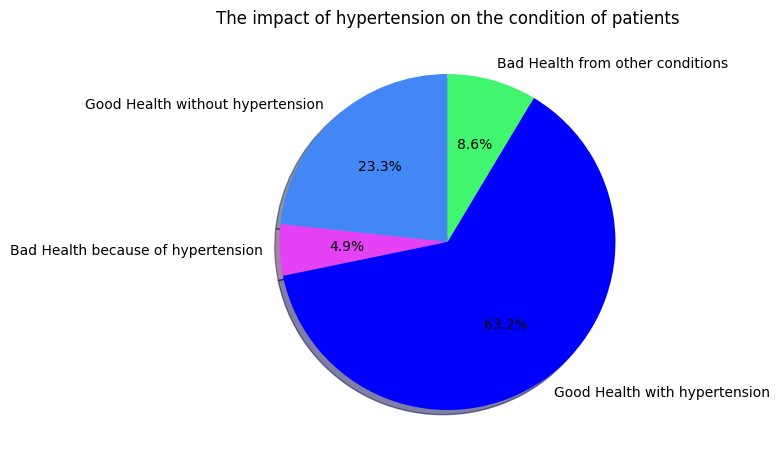

In [87]:
df = data_as_csv 
fig = plt.figure(figsize=(12,7)) 

ax2 = fig.add_axes([0.1,0.4, 0.4,0.6]) 
lab = ['Good Health without hypertension', 'Bad Health because of hypertension', 'Good Health with hypertension', 'Bad Health from other conditions'] 
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

#42f56f
ax2.pie(df.groupby(by=['Hipertensiv','Stare']).Stare.count(), autopct= '%1.1f%%', shadow=True,startangle=90, labels=lab,colors=colors) 
plt.title('The impact of hypertension on the condition of patients') 
plt.show()

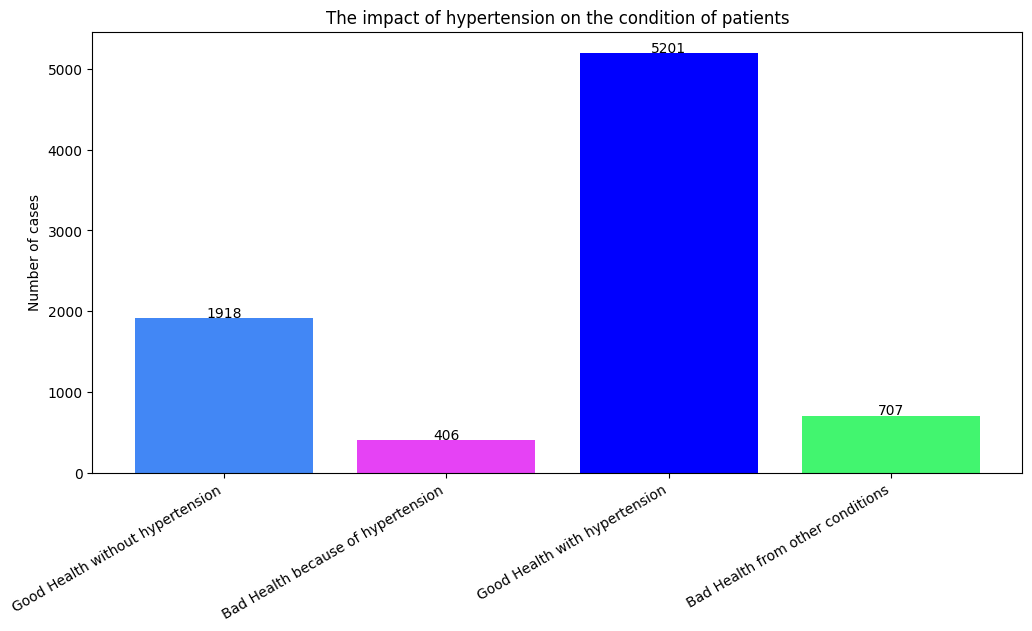

In [88]:
import matplotlib.pyplot as plt

# Date de exemplu
lab = ['Good Health without hypertension', 'Bad Health because of hypertension', 'Good Health with hypertension', 'Bad Health from other conditions']  
counts = df.groupby(by=['Hipertensiv', 'Stare']).Stare.count()

# Culorile dorite pentru fiecare categorie
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

# Crearea graficului bar chart
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(lab, counts,color=colors)

# Adăugarea valorilor pentru fiecare bară
for i, v in enumerate(counts):
    ax.text(i, v + 10, str(v), ha='center')

# Etichetele axelor
ax.set_ylabel('Number of cases')

# Titlul graficului
plt.title('The impact of hypertension on the condition of patients')
ax.bar(lab, counts, color=colors)
plt.xticks(rotation=30, ha='right')
plt.subplots_adjust(bottom=0.25)
# Afișarea graficului
plt.show()

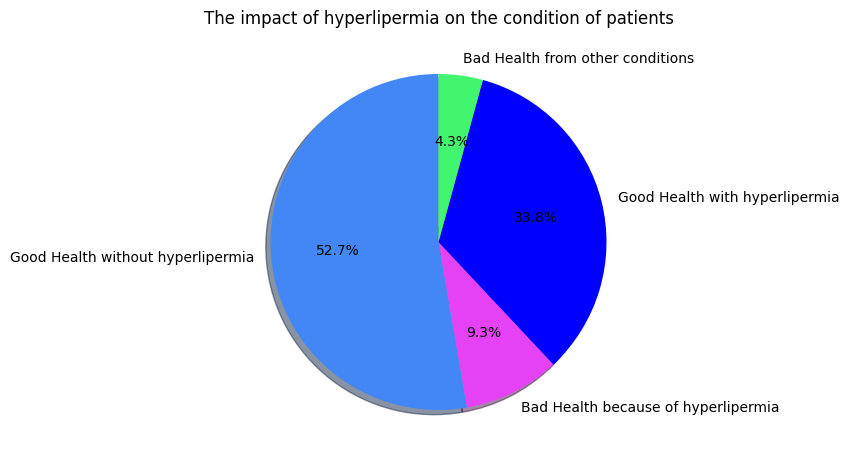

In [89]:
df = data_as_csv 
fig = plt.figure(figsize=(12,7)) 

ax2 = fig.add_axes([0.1,0.4, 0.4,0.6]) 
lab = ['Good Health without hyperlipermia', 'Bad Health because of hyperlipermia', 'Good Health with hyperlipermia', 'Bad Health from other conditions'] 
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

#42f56f
ax2.pie(df.groupby(by=['Hiperlipemie','Stare']).Stare.count(), autopct= '%1.1f%%', shadow=True,startangle=90, labels=lab,colors=colors) 
plt.title('The impact of hyperlipermia on the condition of patients') 
plt.show()

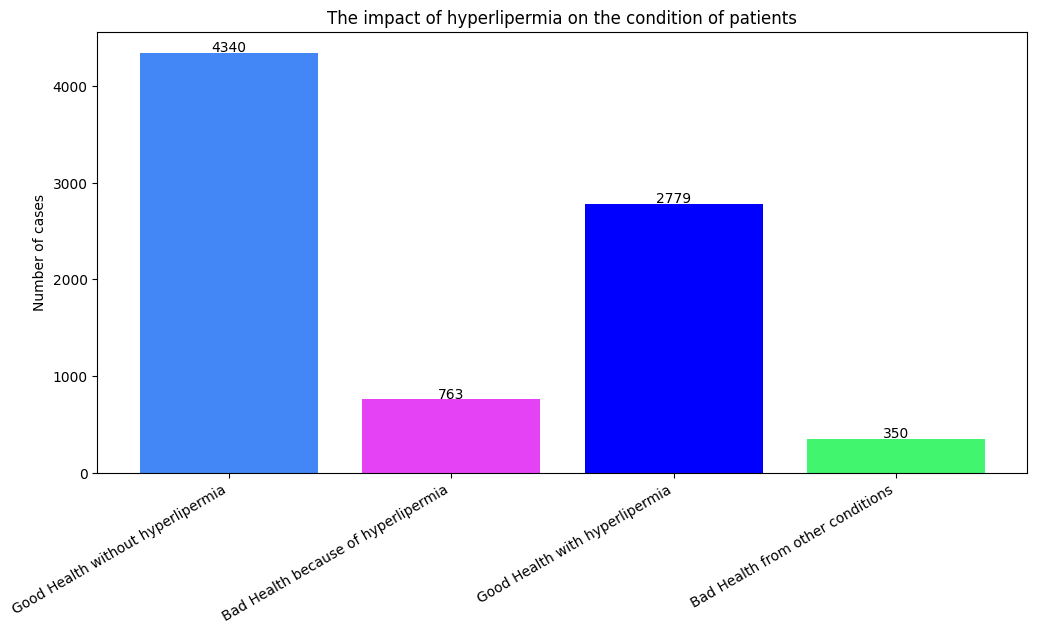

In [90]:
import matplotlib.pyplot as plt

# Date de exemplu
lab = ['Good Health without hyperlipermia', 'Bad Health because of hyperlipermia', 'Good Health with hyperlipermia', 'Bad Health from other conditions'] 
counts = df.groupby(by=['Hiperlipemie', 'Stare']).Stare.count()

# Culorile dorite pentru fiecare categorie
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

# Crearea graficului bar chart
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(lab, counts,color=colors)

# Adăugarea valorilor pentru fiecare bară
for i, v in enumerate(counts):
    ax.text(i, v + 10, str(v), ha='center')

# Etichetele axelor
ax.set_ylabel('Number of cases')

# Titlul graficului
plt.title('The impact of hyperlipermia on the condition of patients')
ax.bar(lab, counts, color=colors)
plt.xticks(rotation=30, ha='right')
plt.subplots_adjust(bottom=0.25)
# Afișarea graficului
plt.show()

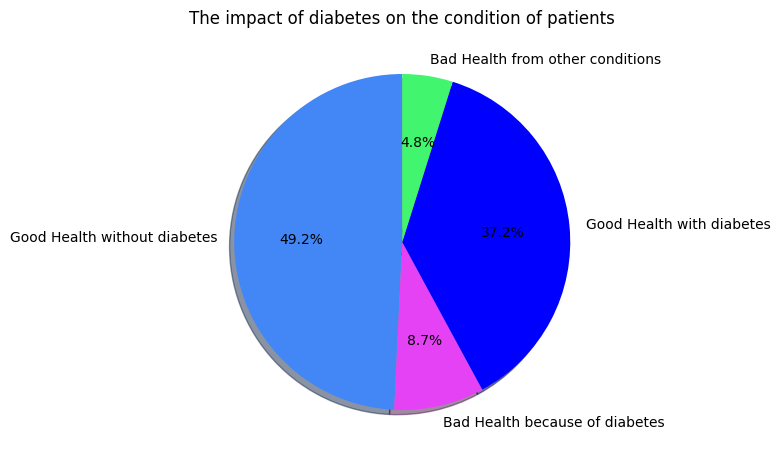

In [91]:
df = data_as_csv 
fig = plt.figure(figsize=(12,7)) 

ax2 = fig.add_axes([0.1,0.4, 0.4,0.6]) 
lab = ['Good Health without diabetes', 'Bad Health because of diabetes', 'Good Health with diabetes', 'Bad Health from other conditions'] 
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

#42f56f
ax2.pie(df.groupby(by=['Diabet','Stare']).Stare.count(), autopct= '%1.1f%%', shadow=True,startangle=90, labels=lab,colors=colors) 
plt.title('The impact of diabetes on the condition of patients') 
plt.show()

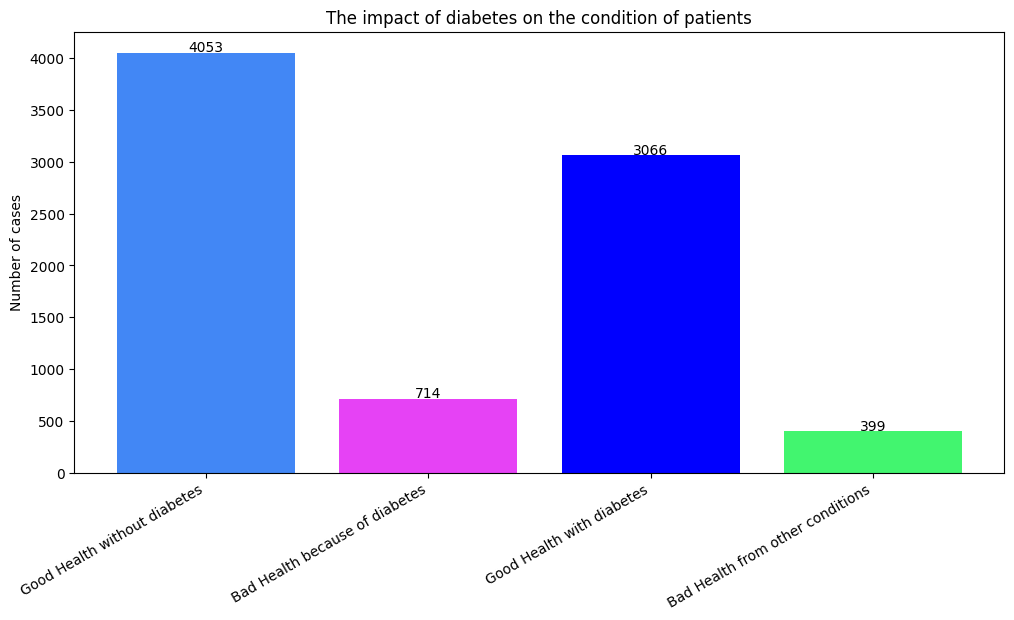

In [92]:
import matplotlib.pyplot as plt

# Date de exemplu
lab = ['Good Health without diabetes', 'Bad Health because of diabetes', 'Good Health with diabetes', 'Bad Health from other conditions'] 
counts = df.groupby(by=['Diabet', 'Stare']).Stare.count()

# Culorile dorite pentru fiecare categorie
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

# Crearea graficului bar chart
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(lab, counts,color=colors)

# Adăugarea valorilor pentru fiecare bară
for i, v in enumerate(counts):
    ax.text(i, v + 10, str(v), ha='center')

# Etichetele axelor
ax.set_ylabel('Number of cases')

# Titlul graficului
plt.title('The impact of diabetes on the condition of patients')
ax.bar(lab, counts, color=colors)
plt.xticks(rotation=30, ha='right')
plt.subplots_adjust(bottom=0.25)
# Afișarea graficului
plt.show()

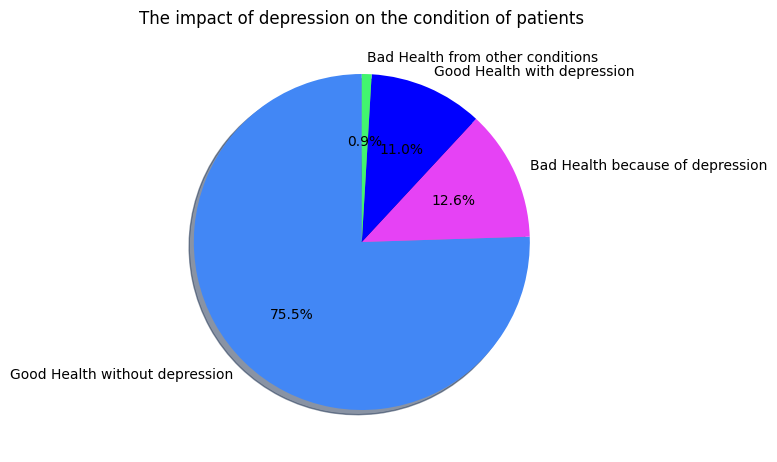

In [93]:
df = data_as_csv 
fig = plt.figure(figsize=(12,7)) 

ax2 = fig.add_axes([0.1,0.4, 0.4,0.6]) 
lab = ['Good Health without depression', 'Bad Health because of depression', 'Good Health with depression', 'Bad Health from other conditions'] 
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

#42f56f
ax2.pie(df.groupby(by=['Depresie','Stare']).Stare.count(), autopct= '%1.1f%%', shadow=True,startangle=90, labels=lab,colors=colors) 
plt.title('The impact of depression on the condition of patients') 
plt.show()

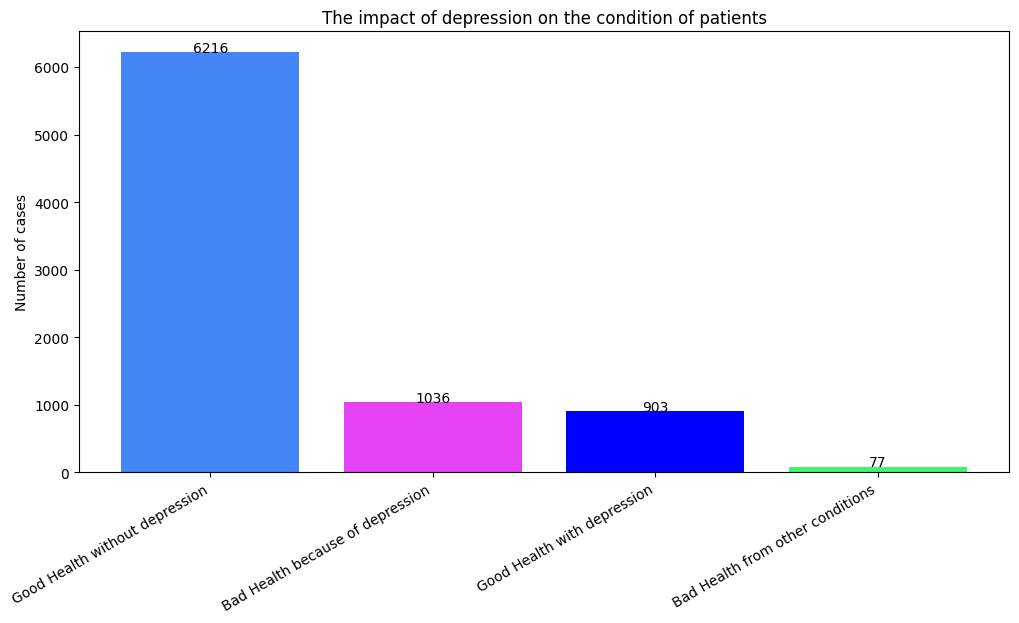

In [94]:
import matplotlib.pyplot as plt

# Date de exemplu
lab = ['Good Health without depression', 'Bad Health because of depression', 'Good Health with depression', 'Bad Health from other conditions'] 
counts = df.groupby(by=['Depresie', 'Stare']).Stare.count()

# Culorile dorite pentru fiecare categorie
colors = ['#4287f5', '#e642f5', 'blue', '#42f56f']  # Culorile corespunzătoare categoriilor

# Crearea graficului bar chart
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(lab, counts,color=colors)

# Adăugarea valorilor pentru fiecare bară
for i, v in enumerate(counts):
    ax.text(i, v + 10, str(v), ha='center')

# Etichetele axelor
ax.set_ylabel('Number of cases')

# Titlul graficului
plt.title('The impact of depression on the condition of patients')
ax.bar(lab, counts, color=colors)
plt.xticks(rotation=30, ha='right')
plt.subplots_adjust(bottom=0.25)
# Afișarea graficului
plt.show()